In [1]:
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Data preparation
image_dir = "/kaggle/input/utk-face-cropped/utkcropped"
data = []
for file_name in os.listdir(image_dir):
    if file_name.endswith(".jpg"):
        try:
            age, gender = map(int, file_name.split("_")[:2])  # Only age and gender
            if gender not in [0, 1]:  # Skip invalid gender values
                print(f"Skipping file with invalid gender: {file_name}")
                continue
            data.append({"file_name": file_name, "age": age, "gender": gender})
        except ValueError:
            print(f"Skipping file: {file_name}")

df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)

# Ensure integer types
df["gender"] = df["gender"].astype(np.int32)
df["age"] = df["age"].astype(np.float32)

Skipping file with invalid gender: 61_3_20170109150557335.jpg.chip.jpg


In [3]:
df.to_csv("utkface_labels.csv", index=False)

In [4]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [5]:
# Function to preprocess images
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_flip_left_right(image)
    return image

In [6]:
# Load data function
def load_data_multi_task(image_dir, dataframe):
    file_paths = [os.path.join(image_dir, fname) for fname in dataframe["file_name"]]
    gender_labels = dataframe["gender"].values.astype(np.int32)
    age_labels = dataframe["age"].values.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, {"gender": gender_labels, "age": age_labels}))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [7]:
# Create datasets
train_dataset = load_data_multi_task(image_dir, train_df).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = load_data_multi_task(image_dir, val_df).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data_multi_task(image_dir, test_df).batch(32).prefetch(tf.data.AUTOTUNE)

In [8]:
# Compute class weights for gender
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_df['gender'].astype(np.int32))
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.9548143486469478, 1: 1.0496748304967483}


In [9]:
# Build model
def build_resnet_multi_task_model():
    base_model = ResNet50(include_top=False, input_shape=(256, 256, 3), weights="imagenet")
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    inputs = layers.Input(shape=(256, 256, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    
    gender_output = layers.Dense(256, activation='relu')(x)
    gender_output = layers.BatchNormalization()(gender_output)
    gender_output = layers.Dropout(0.5)(gender_output)
    gender_output = layers.Dense(1, activation='sigmoid', name="gender")(gender_output)
    
    age_output = layers.Dense(256, activation='relu')(x)
    age_output = layers.BatchNormalization()(age_output)
    age_output = layers.Dropout(0.5)(age_output)
    age_output = layers.Dense(1, activation='linear', name="age")(age_output)
    
    model = models.Model(inputs=inputs, outputs=[gender_output, age_output])
    return model

In [10]:
# Compile and train model
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_resnet_multi_task_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss={"gender": "binary_crossentropy", "age": "mae"},
        metrics={"gender": "accuracy", "age": "mae"}
    )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,639,362 (93.99 MB)

 Trainable params: 24,585,218 (93.79 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [12]:
# Checkpoint
checkpoint = ModelCheckpoint(
    filepath='resnet50_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[checkpoint]
)

Epoch 1/15
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - age_mae: 33.2821 - gender_accuracy: 0.7438 - loss: 33.8597
Epoch 1: val_loss improved from inf to 42.81828, saving model to resnet50_best_model.keras
475/475 ━━━━━━━━━━━━━━━━━━━━ 369s 451ms/step - age_mae: 33.2809 - gender_accuracy: 0.7438 - loss: 33.8584 - val_age_mae: 33.8508 - val_gender_accuracy: 0.5256 - val_loss: 42.8183
Epoch 2/15
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - age_mae: 31.9075 - gender_accuracy: 0.8531 - loss: 32.2618
Epoch 2: val_loss improved from 42.81828 to 32.60581, saving model to resnet50_best_model.keras
475/475 ━━━━━━━━━━━━━━━━━━━━ 222s 448ms/step - age_mae: 31.9066 - gender_accuracy: 0.8531 - loss: 32.2609 - val_age_mae: 32.2479 - val_gender_accuracy: 0.8603 - val_loss: 32.6058
Epoch 3/15
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - age_mae: 30.2329 - gender_accuracy: 0.8699 - loss: 30.5434
Epoch 3: val_loss improved from 32.60581 to 29.53780, saving model to resnet50_best_model.keras
475/475 ━━━━━━

In [13]:
# Evaluate on test set
test_results = model.evaluate(test_dataset)
print(f"Test Results - Gender Accuracy: {test_results[1]:.2%}, Age MAE: {test_results[2]:.2f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - age_mae: 5.9881 - gender_accuracy: 0.9000 - loss: 6.2243
Test Results - Gender Accuracy: 592.15%, Age MAE: 0.90


In [14]:
# Plot results
def plot_model_results(model, test_dataset, num_samples=5):
    y_true_gender = []
    y_pred_gender = []
    y_true_age = []
    y_pred_age = []
    for images, labels in test_dataset:
        gender_true = labels['gender'].numpy()
        age_true = labels['age'].numpy()
        y_true_gender.extend(gender_true)
        y_true_age.extend(age_true)
        gender_pred, age_pred = model.predict(images, verbose=0)
        gender_pred = (gender_pred > 0.5).astype(int).flatten()
        age_pred = age_pred.flatten()
        y_pred_gender.extend(gender_pred)
        y_pred_age.extend(age_pred)
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(y_true_gender, y_pred_gender)
    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.title('Confusion Matrix for Gender Classification')
    class_report = classification_report(y_true_gender, y_pred_gender, target_names=['Male', 'Female'], output_dict=False)
    plt.subplot(2, 2, 2)
    plt.text(0.0, 1.0, f'Classification Report:\n\n{class_report}', fontsize=10, va='top', ha='left', family='monospace')
    plt.axis('off')
    plt.title('Gender Classification Report')
    age_errors = np.abs(np.array(y_true_age) - np.array(y_pred_age))
    plt.subplot(2, 2, 3)
    plt.hist(age_errors, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Absolute Age Error (Years)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Age Prediction Errors')
    plt.grid(True, alpha=0.3)
    plt.subplot(2, 2, 4)
    for i, (images, labels) in enumerate(test_dataset.take(1)):
        preds = model.predict(images, verbose=0)
        gender_preds = (preds[0] > 0.5).astype(int).flatten()
        age_preds = (preds[1]).flatten()
        for j in range(min(num_samples, len(images))):
            plt.subplot(2, num_samples, num_samples + j + 1)
            plt.imshow(images[j].numpy())
            plt.title(f"True: {'M' if labels['gender'][j].numpy() == 0 else 'F'}, {labels['age'][j].numpy():.0f}y\n"
                      f"Pred: {'M' if gender_preds[j] == 0 else 'F'}, {age_preds[j]:.1f}y",
                      fontsize=8)
            plt.axis('off')
    plt.suptitle('Sample Predictions', fontsize=10, y=0.65)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_23/3469750556.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, num_samples, num_samples + j + 1)
/tmp/ipykernel_23/3469750556.py:49: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


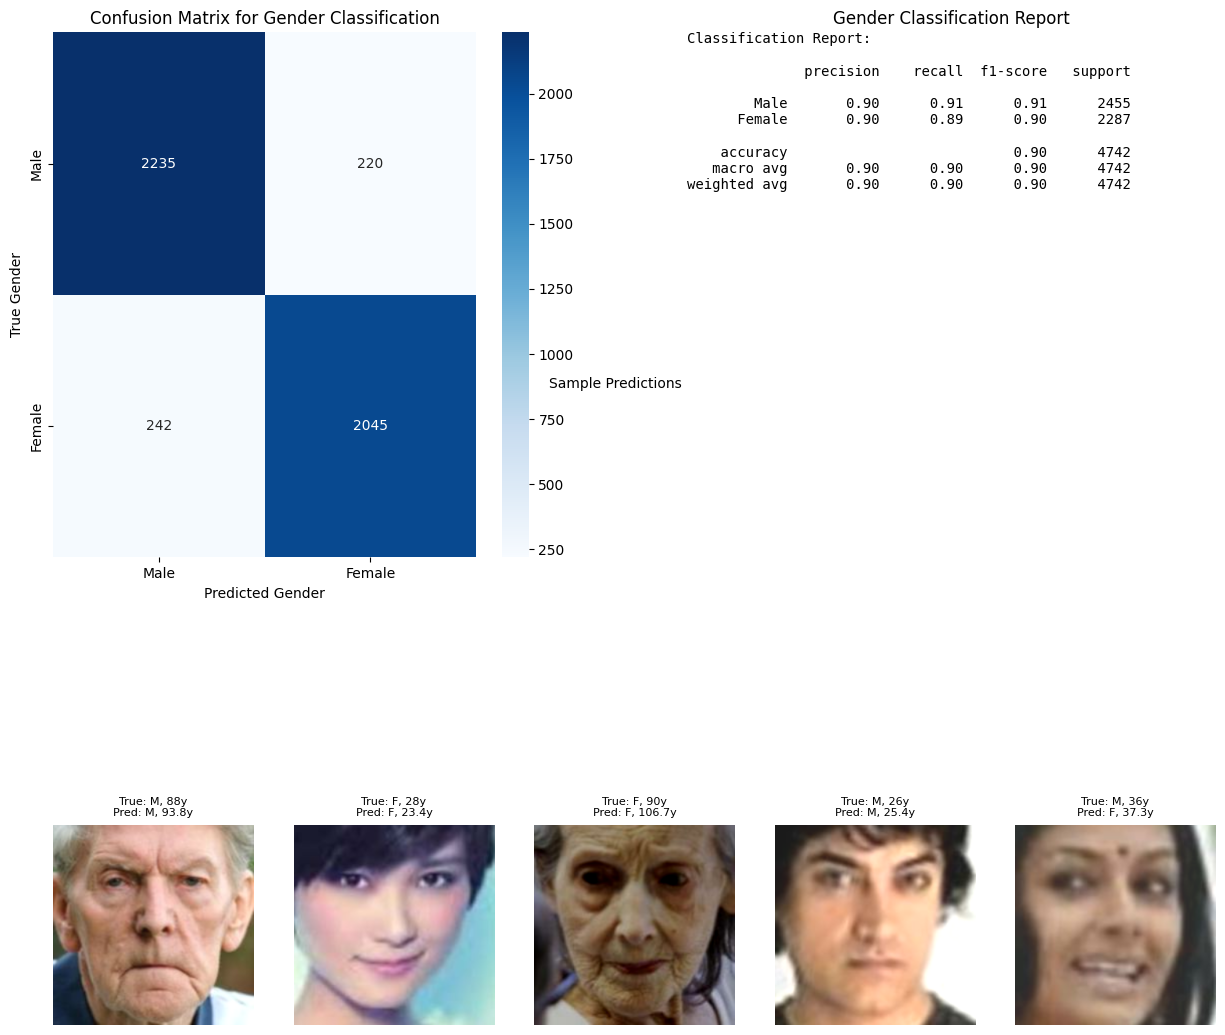

In [15]:
# Call the function with the model and test dataset
plot_model_results(model, test_dataset, num_samples=5)